In [1]:
import sys
sys.path.append("../../../../")
sys.path.append("../../")

In [2]:
!pip install -q wandb 

In [3]:
import os
import torch
from torch import nn
from dotenv import load_dotenv
from huggingface_hub import login
from pricer.items import Item
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

In [4]:
load_dotenv(override = True)
hf_token = ""
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
username = "ed-donner"
dataset = f"{username}/items_lite"

train, val, test = Item.get_from_hub(dataset)
items = train + val + test

print(f"Loaded {len(train):,} training items, {len(val):,} validation items, {len(test):,} test items")

Loaded 20,000 training items, 1,000 validation items, 1,000 test items


In [6]:
BASE_MODEL="meta-llama/Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

In [7]:
tokenizer.encode(" you are what , I am a guy")

[128000, 499, 527, 1148, 1174, 358, 1097, 264, 7564]

In [8]:
token_counts = [item.count_tokens(tokenizer) for item in tqdm(items)]

  0%|          | 0/22000 [00:00<?, ?it/s]

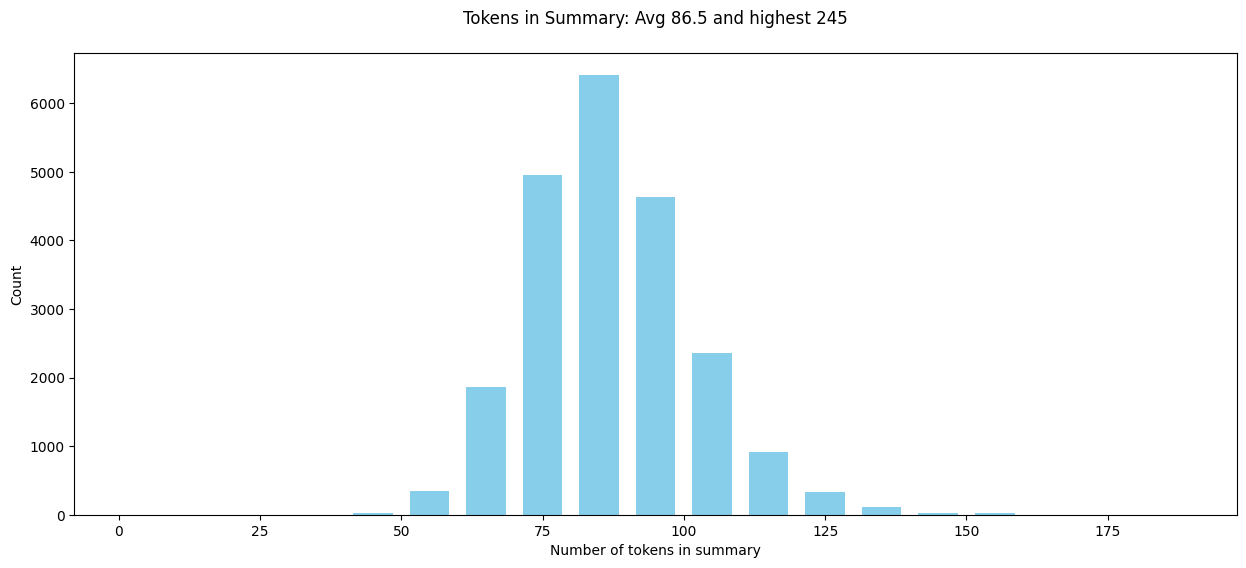

In [9]:
plt.figure(figsize=(15, 6))
plt.title(f"Tokens in Summary: Avg {sum(token_counts)/len(token_counts):,.1f} and highest {max(token_counts):,}\n")
plt.xlabel('Number of tokens in summary')
plt.ylabel('Count')
plt.hist(token_counts, rwidth=0.7, color="skyblue", bins=range(0, 200, 10))
plt.show()

In [10]:
CUTOFF = 120
cut = len([count for count in token_counts if count > CUTOFF])
print(f"With this CUTOFF, we will truncate {cut:,} items which is {cut/len(items):.1%}")

With this CUTOFF, we will truncate 439 items which is 2.0%


In [11]:
for item in tqdm(train+val):
    item.make_prompts(tokenizer, CUTOFF, True)
for item in tqdm(test):
    item.make_prompts(tokenizer, CUTOFF, False)

  0%|          | 0/21000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
print("PROMPT:")
print(test[0].prompt)
print("COMPLETION:")
print(test[0].completion)

PROMPT:
What is the price of the product, rounded to the nearest dollar?

Title: Excess V2 Distortion/Modulation Pedal  
Category: Music Pedals  
Brand: Old Blood Noise  
Description: A versatile pedal offering distortion and three modulation modes—delay, chorus, and harmonized fifths—with full control over signal routing and expression.  
Details: Features include separate gain, tone, and volume controls; time, depth, and volume per modulation; order switching, soft‑touch bypass, and expression jack for dynamic control.

Price is $
COMPLETION:
219.0


In [13]:
prompt_token_counts = [item.count_prompt_tokens(tokenizer) for item in tqdm(items)]

  0%|          | 0/22000 [00:00<?, ?it/s]

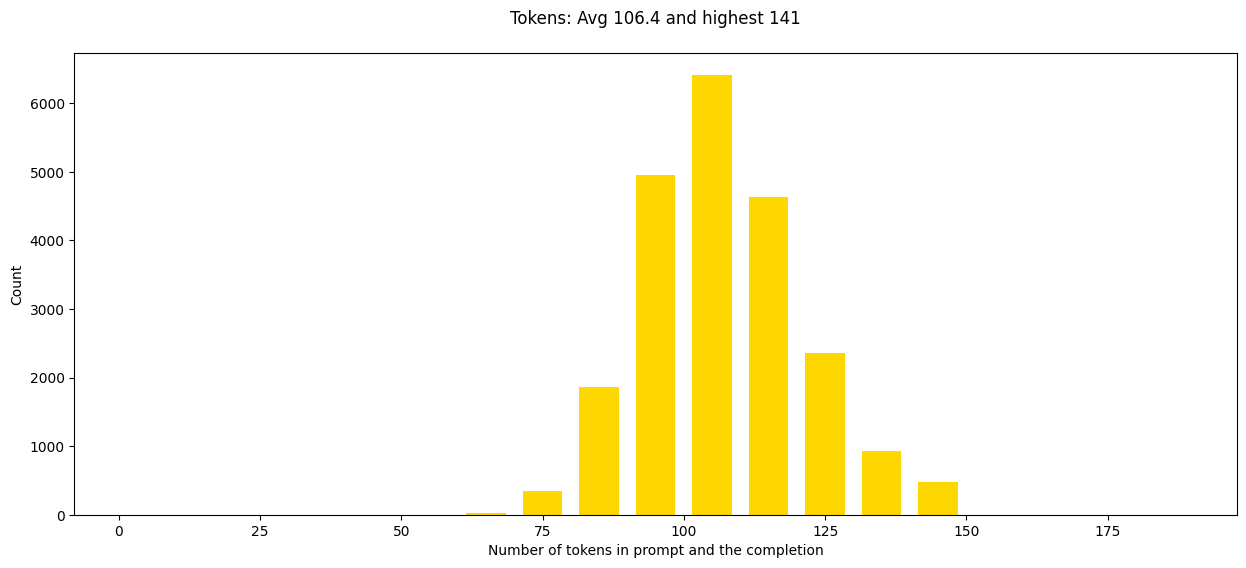

In [14]:
plt.figure(figsize=(15, 6))
plt.title(f"Tokens: Avg {sum(prompt_token_counts)/len(prompt_token_counts):,.1f} and highest {max(prompt_token_counts):,}\n")
plt.xlabel('Number of tokens in prompt and the completion')
plt.ylabel('Count')
plt.hist(prompt_token_counts, rwidth=0.7, color="gold", bins=range(0, 200, 10))
plt.show()

In [16]:
username = "ujalaarshad17"
dataset = f"{username}/items_prompts"

Item.push_to_hub(dataset, train, val, test)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

### We will just set the max-sequence length of 148